In [1]:
import os
from pathlib import Path
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof
import re
import cv2
from sklearn.model_selection import train_test_split

print(tf.__version__)


2.8.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_folder = 'drive/MyDrive/newData'
sub_folder_list = os.listdir(input_folder)
# input_folder = pathlib.Path("drive/MyDrive/newData")
# bow_playing_dir = input_folder / "bowPlaying"

data_images_with_labels = []
data_images = []
data_labels = []
for i in range(len(sub_folder_list)):
    if sub_folder_list[i]=='bowPlaying':
        int_label = 0
    if sub_folder_list[i]=='notPlaying':
        int_label = 1
    if sub_folder_list[i]=='pizz':
        int_label = 2
    # if sub_folder_list[i]=='unsure':
    #     int_label = 3
    #print(os.path.join(input_folder,sub_folder_list[i]))
    images_list = os.listdir(os.path.join(input_folder,sub_folder_list[i]))
    #print(images_list)
    images_list.sort(key=lambda f: int(re.sub('\D', '', f)))
    #print(images_list)

    for j in range(len(images_list)):
        img_rgb = cv2.imread(os.path.join(input_folder,sub_folder_list[i],images_list[j]))
        img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
        # ABOVE LINE CONVERTS TO GREYSCALE
        #data_images_with_labels.append([img,sub_folder_list[i]])
        data_images.append(img)
        
        data_labels.append(int_label)


X_train, X_test, y_train, y_test = train_test_split(data_images, data_labels, test_size=0.33, random_state=42)
train_images = np.asarray(X_train, dtype=None, order=None)
test_images = np.asarray(X_test, dtype=None, order=None)
train_labels = np.asarray(y_train, dtype=None, order=None)
test_labels = np.asarray(y_test, dtype=None, order=None)

In [4]:
"""# Helper Functions"""

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [5]:
print(train_images.shape)
print(train_labels[2])

class_names = ['bow_playing', 'not_playing', 'pizz']

"""## Explore the data"""

train_images.shape

len(train_labels)

np.unique(train_labels)


(9263, 200, 200)
0


array([0, 1, 2])

You should have a separate file that maps your class labels to your class names. 

Since tf.keras.utils.image_dataset_from_directory will generate labels, just write down somewhere which number is associated to which, rather than it being based on position.
```
class_names = ['bowPlaying', 'notPlaying', 'pizz']
```

In [6]:
"""# Test Dataset"""

test_images.shape

len(test_labels)


4563

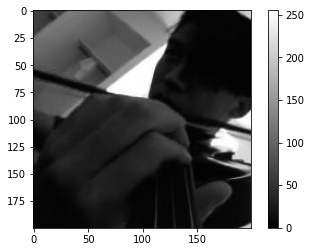

In [7]:
"""## Preprocessing"""

train_img = train_images[2]
plt.figure()
plt.imshow(train_images[2], cmap="gray")
# plt.imshow(train_images[2])
plt.colorbar()
plt.grid(False)
plt.show()
#
train_images = train_images / 255.0
test_images = test_images / 255.0


In [9]:
"""## Build & Compile the model

"""

model = keras.Sequential([
    Flatten(input_shape=(200, 200, 1)), 
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)), #12 is underfitting, 13 is overfitting
    Dense(3, activation='softmax') #this
])

model.summary()


# model.compile(optimizer='adam',
#               loss= SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.5),
#     loss=SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[
#         tf.keras.metrics.BinaryAccuracy(name='accuracy')
#     ]
# )
STEPS_PER_EPOCH = 290

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0000001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

# def get_optimizer():
#   return tf.keras.optimizers.Adam(lr_schedule)

model.compile(tf.keras.optimizers.Adam(lr_schedule),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# model.compile(tf.keras.optimizers.schedules.InverseTimeDecay,
#               loss= SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=40) #damn only 1 lol

KERAS_MODEL_NAME = "tf_model.h5"

model.save(KERAS_MODEL_NAME)

convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

keras_model_size = get_file_size(KERAS_MODEL_NAME)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2560064   
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,560,259
Trainable params: 2,560,259
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


290/290 [==============================] - 10s 32ms/step - loss: 1.1753 - accuracy: 0.4122
Epoch 2/40
290/290 [==============================] - 9s 30ms/step - loss: 1.0570 - accuracy: 0.6598
Epoch 3/40
290/290 [==============================] - 9s 30ms/step - loss: 0.9680 - accuracy: 0.7441
Epoch 4/40
290/290 [==============================] - 9s 30ms/step - loss: 0.9008 - accuracy: 0.7705
Epoch 5/40
290/290 [==============================] - 9s 31ms/step - loss: 0.8464 - accuracy: 0.7765
Epoch 6/40
290/290 [==============================] - 9s 32ms/step - loss: 0.7997 - accuracy: 0.7886
Epoch 7/40
290/290 [==============================] - 9s 31ms/step - loss: 0.7581 - accuracy: 0.7978
Epoch 8/40
290/290 [==============================] - 9s 31ms/step - loss: 0.7237 - accuracy: 0.8077
Epoch 9/40
290/290 [==============================] - 9s 31ms/step - loss: 0.6941 - accuracy: 0.8222
Epoch 10/40
290/290 [==============================] - 9s 31ms/step - loss: 0.6679 - accuracy: 0.8316

In [10]:
"""# TF Lite Model"""

TF_LITE_MODEL_FILE_NAME = "tf_lite_model_jul25.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_MODEL_FILE_NAME #A CHANGE HERE
with open(tflite_model_name, "wb") as file:
  file.write(tflite_model)

convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

INFO:tensorflow:Assets written to: /tmp/tmp1h7h6t26/assets


File size: 10002.758 Kilobytes


In [11]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 200, 200, 1) #1 instead of 3
        yield [data.astype(np.float32)]

# Convert the tflite.
converter = lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

# Save the model.
with open('tf_lite_model_quantized.tflite', 'wb') as f:
  f.write(tflite_quant_model)

convert_bytes(get_file_size('tf_lite_model_quantized.tflite'), "KB")

tflite_file_size = get_file_size('tf_lite_model_quantized.tflite')


INFO:tensorflow:Assets written to: /tmp/tmp6d36rjf1/assets


INFO:tensorflow:Assets written to: /tmp/tmp6d36rjf1/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


File size: 2502.477 Kilobytes


600
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 0
1
prediction is: 2
1
prediction is: 0
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 0
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 0
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 0
1
prediction is: 0
1
prediction is: 2
1
prediction is: 2
1
prediction is: 0
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 0
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 2
1
prediction is: 0
1
prediction is: 2
1
prediction is: 0
1
predicti

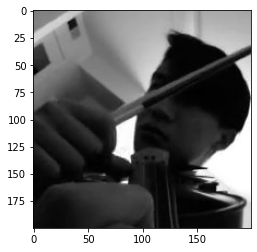

In [12]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])


  test_folder = 'drive/MyDrive/test'
  # test_folder = 'drive/MyDrive/newData/notPlaying'
  test_images = os.listdir(test_folder)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i in range(len(test_images)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image_rgb = cv2.imread(os.path.join(test_folder,test_images[i]))
    test_image = cv2.cvtColor(test_image_rgb, cv2.COLOR_BGR2GRAY)
    # print(test_image)
    # print(interpreter.get_input_details())
    plt.imshow(test_image, cmap="gray")
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    test_image = np.expand_dims(test_image, axis=3).astype(np.float32) #4 dimensions i think is fucking it up


    # print(test_image.shape)
    # print(interpreter.get_input_details())
    # print(input_tensor_index)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels (txt) to calculate accuracy.
  def readFile(fileName):
      fileObj = open(fileName, "r") #opens the file in read mode
      words = fileObj.read().splitlines() #puts the file into an array
      fileObj.close()
      return words

  test_labels = readFile('drive/MyDrive/test_labels.txt')

  accurate_count = 0
  print(len(prediction_digits))
  for index in range(len(prediction_digits)):
    print('prediction is: ' + str(prediction_digits[index]))
    print(test_labels[index])
    if str(prediction_digits[index]) == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

def evaluate_tflite_quant_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])


  test_folder = 'drive/MyDrive/test'
  # test_folder = 'drive/MyDrive/newData/notPlaying'
  test_images = os.listdir(test_folder)

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i in range(len(test_images)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image_rgb = cv2.imread(os.path.join(test_folder,test_images[i]))
    test_image = cv2.cvtColor(test_image_rgb, cv2.COLOR_BGR2GRAY)
    # print(test_image)
    # print(interpreter.get_input_details())
    plt.imshow(test_image, cmap="gray")
    test_image = np.expand_dims(test_image, axis=0).astype(np.int8)
    test_image = np.expand_dims(test_image, axis=3).astype(np.int8) #4 dimensions i think is fucking it up


    # print(test_image.shape)
    # print(interpreter.get_input_details())
    # print(input_tensor_index)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels (txt) to calculate accuracy.
  def readFile(fileName):
      fileObj = open(fileName, "r") #opens the file in read mode
      words = fileObj.read().splitlines() #puts the file into an array
      fileObj.close()
      return words

  test_labels = readFile('drive/MyDrive/test_labels.txt')

  accurate_count = 0
  print(len(prediction_digits))
  for index in range(len(prediction_digits)):
    print('prediction is: ' + str(prediction_digits[index]))
    print(test_labels[index])
    if str(prediction_digits[index]) == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy



# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
newaccuracy = evaluate_tflite_model(tflite_model)
print('Float model accuracy = %.4f' % newaccuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)

quantized_accuracy = evaluate_tflite_quant_model(tflite_quant_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (newaccuracy - quantized_accuracy))

